# Tranfer Learning over Shufflnetv2

Fine Tuning a Shufflenet model (pre-trained over Imagenet) on the CIFAR-10 Dataset.

In [2]:
from time import time
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import torchvision
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary


#### Training, Valiation Loop

In [13]:
def train_test(model, trainload, testload, loss, optim, epochs, device):
    start_time = time()
    print(f'Start Time: {start_time}')

    # Store metrics
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        model.train()
        total_step = len(trainload)
        running_loss, running_corrects = 0, 0

        for i, (inputs, labels) in enumerate(trainload):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # train
            optim.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs) # prediction
                _loss = loss(outputs, labels) # loss
                _, pred = torch.max(outputs, 1)

                # backpropr
                _loss.backward()
                optim.step()

            running_loss += _loss.item() * inputs.size(0)
            running_corrects += torch.sum(pred == labels.data)

            # display every 100 samples
            if (i * inputs.size(0)) % 1000 == 0 and i != 0:
                print(f'Epoch {epoch+1}/{epochs}, Step {(i * inputs.size(0))}/{len(trainload.dataset)}, '
                      f'Loss: {running_loss/(i * inputs.size(0)):.2f}, Acc: {running_corrects.double()/(i * inputs.size(0)):.2f}')



        # valdation
        model.eval()
        with torch.no_grad():
            valid_loss, valid_acc = 0.0, 0.0

            for i, (inputs, labels) in enumerate(testload):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # test
                with torch.set_grad_enabled(False):
                    outputs = model(inputs)
                    _, pred = torch.max(outputs, 1)
                    _loss = loss(outputs, labels)

                valid_loss += _loss.item() * inputs.size(0)
                valid_acc += torch.sum(pred == labels.data)

            print(f'Epoch #{epoch+1}, '
                    f'Validation Loss: {valid_loss/len(testload.dataset):.2f}, '
                    f'Validation Acc: {valid_acc.double()/len(testload.dataset):.2f}')

        # Save losses for plotting
        train_losses.append(running_loss/len(trainload.dataset))
        valid_losses.append(valid_loss/len(testload.dataset))

    print(f'Training time: {start_time - time()}')
    print('Savin model')
    torch.save(model.state_dict(), 'my_shufflenet.pt')

    return train_losses, valid_losses


In [8]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=True)
model.eval()
model.cuda()
summary(model, (3, 224, 224))

Using cache found in /home/local/ASUAD/nkondepu/.cache/torch/hub/pytorch_vision_v0.10.0
/home/local/ASUAD/nkondepu/anaconda3/envs/cen598/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/local/ASUAD/nkondepu/anaconda3/envs/cen598/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
         MaxPool2d-4           [-1, 24, 56, 56]               0
            Conv2d-5           [-1, 24, 28, 28]             216
       BatchNorm2d-6           [-1, 24, 28, 28]              48
            Conv2d-7           [-1, 58, 28, 28]           1,392
       BatchNorm2d-8           [-1, 58, 28, 28]             116
              ReLU-9           [-1, 58, 28, 28]               0
           Conv2d-10           [-1, 58, 56, 56]           1,392
      BatchNorm2d-11           [-1, 58, 56, 56]             116
             ReLU-12           [-1, 58, 56, 56]               0
           Conv2d-13           [-1, 58, 28, 28]             522
      BatchNorm2d-14           [-1, 58,

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Freeze network params
- Freeze all params in the network
- Replace the final classification layer with a new one to train.

In [10]:
# freeze all model params
for params in model.parameters():
    params.requires_grad = False

numftrs = model.fc.in_features
model.fc = nn.Linear(numftrs, 10)

model = model.to(device)

#### Default transformations

In [11]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.247, 0.243, 0.261)
    )
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.247, 0.243, 0.261)
    )
])

#### Dataloaders

In [12]:
batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                    download=True, transform=test_transforms)
testloader = DataLoader(testset, batch_size=batch_size,shuffle=False)

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [14]:
tloss, vloss = train_test(
        model=model,
        trainload=trainloader,
        testload=testloader,
        loss=nn.CrossEntropyLoss(),
        optim=optim.Adam(model.parameters(), lr=1e-3),
        epochs=35,
        device=device
    )
print('==END==')

Start Time: 1698541743.9947479
Epoch 1/35, Step 4000/50000, Loss: 2.24, Acc: 0.28
Epoch 1/35, Step 8000/50000, Loss: 2.15, Acc: 0.43
Epoch 1/35, Step 12000/50000, Loss: 2.07, Acc: 0.51
Epoch 1/35, Step 16000/50000, Loss: 2.01, Acc: 0.55
Epoch 1/35, Step 20000/50000, Loss: 1.95, Acc: 0.57
Epoch 1/35, Step 24000/50000, Loss: 1.89, Acc: 0.59
Epoch 1/35, Step 28000/50000, Loss: 1.84, Acc: 0.61
Epoch 1/35, Step 32000/50000, Loss: 1.79, Acc: 0.62
Epoch 1/35, Step 36000/50000, Loss: 1.75, Acc: 0.63
Epoch 1/35, Step 40000/50000, Loss: 1.71, Acc: 0.63
Epoch 1/35, Step 44000/50000, Loss: 1.67, Acc: 0.64
Epoch 1/35, Step 48000/50000, Loss: 1.64, Acc: 0.65
Epoch #1, Validation Loss: 1.18, Validation Acc: 0.73
Epoch 2/35, Step 4000/50000, Loss: 1.22, Acc: 0.71
Epoch 2/35, Step 8000/50000, Loss: 1.20, Acc: 0.72
Epoch 2/35, Step 12000/50000, Loss: 1.18, Acc: 0.72
Epoch 2/35, Step 16000/50000, Loss: 1.16, Acc: 0.72
Epoch 2/35, Step 20000/50000, Loss: 1.15, Acc: 0.72
Epoch 2/35, Step 24000/50000, Loss:

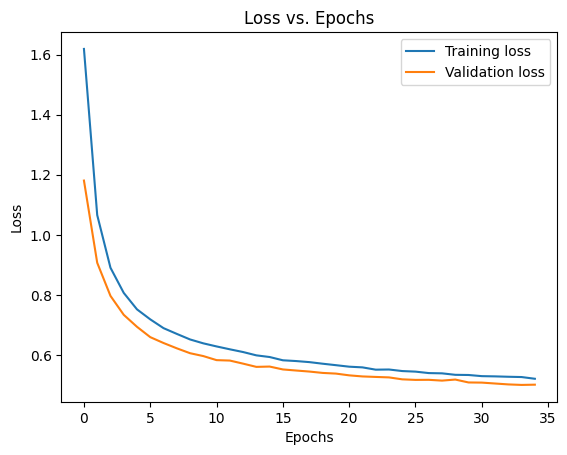

In [15]:
# Plotting training and validation loss
plt.plot(tloss, label='Training loss')
plt.plot(vloss, label='Validation loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Confusion matrix

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Assuming model is your trained PyTorch model, and test_loader is your DataLoader for the test set
model.cpu().eval()  # Set the model to evaluation mode

# Collect all the predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():  # No gradients needed
    for data, labels in testloader:
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

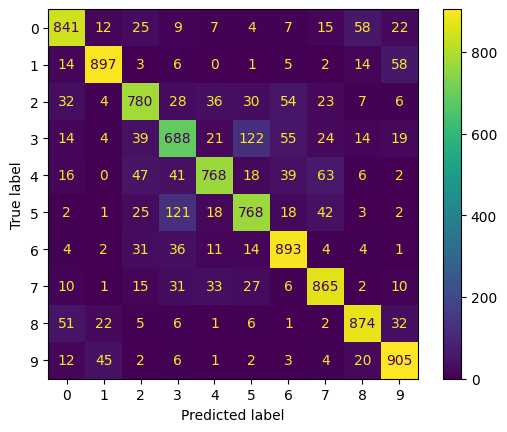

In [18]:
# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
# disp.plot(cmap=plt.cm.Blues)

plt.show()